# Gesture Recognition
![1607_2716_0 (1)](https://user-images.githubusercontent.com/93203186/172011187-70099885-05f6-4e4a-9dbe-e4db30471f54.jpg)


> Imagine working as a data scientist at a home electronics company which manufactures state of the art smart televisions. You want to develop a cool feature in the smart-TV that can recognise five different gestures performed by the user which will help users control the TV without using a remote. 
> The gestures are continuously monitored by the webcam mounted on the TV. Each gesture corresponds to a specific command:

- Thumbs up:  Increase the volume
- Thumbs down: Decrease the volume
- Left swipe: 'Jump' backwards 10 seconds
- Right swipe: 'Jump' forward 10 seconds  
- Stop: Pause the movie

## Understanding the Dataset
> The training data consists of a few hundred videos categorised into one of the five classes. Each video (typically 2-3 seconds long) is divided into a sequence of 30 frames(images). These videos have been recorded by various people performing one of the five gestures in front of a webcam - similar to what the smart TV will use. 

> The data is in a zip file. The zip file contains a 'train' and a 'val' folder with two CSV files for the two folders. These folders are in turn divided into subfolders where each subfolder represents a video of a particular gesture. Each subfolder, i.e. a video, contains 30 frames (or images). Note that all images in a particular video subfolder have the same dimensions but different videos may have different dimensions. Specifically, videos have two types of dimensions - either 360x360 or 120x160 (depending on the webcam used to record the videos). Hence, you will need to do some pre-processing to standardise the videos. 

> Each row of the CSV file represents one video and contains three main pieces of information - the name of the subfolder containing the 30 images of the video, the name of the gesture and the numeric label (between 0-4) of the video.

> Here task is to train a model on the 'train' folder which performs well on the 'val' folder as well (as usually done in ML projects). We have withheld the test folder for evaluation purposes - your final model's performance will be tested on the 'test' set.
 
 ## Goals of this Project

> __Generator:__  The generator should be able to take a batch of videos as input without any error. Steps like cropping, resizing and normalization should be performed successfully.

> __Model:__ Develop a model that is able to train without any errors which will be judged on the total number of parameters (as the inference(prediction) time should be less) and the accuracy achieved.

> __Write up:__ This should contain the detailed procedure followed in choosing the final model. The write up should start with the reason for choosing the base model, then highlight the reasons and metrics taken into consideration to modify and experiment to arrive at the final model. 

### Attention

- Few models could result in Resourse exhuasted error (OOM error), in this situation kindly reset kernel and restart same notebook followed by running required cell of respective model.

In [1]:
# Import necessary libraries
import numpy as np
import os
from skimage.transform import resize
from imageio import imread
import datetime

import warnings
warnings.filterwarnings("ignore")
import abc
from sys import getsizeof

In [2]:
# We set the random seed so that the results don't vary drastically.

np.random.seed(30)
import random as rn
rn.seed(30)
from keras import backend as K
import tensorflow as tf
tf.random.set_seed(30)

## Loading Dataset

# Creating Pipline from gmail drive
from google.colab import drive
drive.mount('/content/drive')

In this cell below, we read the folder names for training and validation. We also set the `batch_size` here.

In [3]:
train_doc = np.random.permutation(open('/datasets/Project_data/train.csv').readlines())
val_doc = np.random.permutation(open('/datasets/Project_data/val.csv').readlines())
batch_size = 40

## Generator

This is one of the most important part of the code. The overall structure of the generator has been given here. In the generator, we are going to preprocess the images as you have images of 2 different dimensions as well as create a batch of video frames. (We can experiment with `img_idx`, `y`,`z` and normalization until we can get high accuracy)

In [4]:
# coding to crop and Resize of photosimages
def cropAndResize(image,HEIGHT_DIMENSION,WIDTH_DIMENSION):
    #crop the images and resize them.  
    #Note that the images are of 2 different shape& the conv3D will throw error if the inputs in a batch have different shapes.
    # CROPPING (making aspect ratio same)
    if abs(image.shape[0]-image.shape[1])%2==0 and image.shape[0]!=image.shape[1]:
        dimension_diff=abs(image.shape[0]-image.shape[1])
        cropping_ratio=dimension_diff//2
        if image.shape[0]>image.shape[1]:
            image=image[cropping_ratio:image.shape[0]-cropping_ratio,:,:]
        elif image.shape[0]<image.shape[1]:
            image=image[:,cropping_ratio:image.shape[1]-cropping_ratio,:]
                    
    # RESIZING
    if image.shape[0]>120 or image.shape[1]>120:
        image=resize(image, (120, 120))
    return image

In [6]:
# Defininng Generator function
def generator(source_path, folder_list, batch_size):
    print( 'Source path = ', source_path, '; batch size =', batch_size)
    img_idx = 7,9,10,11,12,13,14,15,16,17,18,19,20,21,22,24 #create a list of image no's you want to use for a particular video
    while True:
        t = np.random.permutation(folder_list)
        num_batches = len(t)//batch_size                 # calculate the number of batches
        remaining_batch_size=len(t)%batch_size
        for batch in range(num_batches):                 # we iterate over the number of batches
            batch_data = np.zeros((batch_size,16,120,120,3)) # x is the no. of images you use for each video,(y,z) is the final size of the input images and 3 is the number of channels RGB
            batch_labels = np.zeros((batch_size,5))      # batch_labels is the one hot representation of the output
            for folder in range(batch_size):             # iterate over the batch_size
                imgs = os.listdir(source_path+'/'+ t[folder + (batch*batch_size)].split(';')[0]) # Read all the images in the folder
                for idx,item in enumerate(img_idx):      # Iterate over the frames/images of a folder to read them in
                    image = imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)
                    image_resized = cropAndResize(image,120,120)                    
                    batch_data[folder,idx,:,:,0] = (image_resized[:,:,0])/255         # Normalise and feed in the image
                    batch_data[folder,idx,:,:,1] = (image_resized[:,:,1])/255         # Normalise and feed in the image
                    batch_data[folder,idx,:,:,2] = (image_resized[:,:,2])/255         # Normalise and feed in the image
                    
                batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1
            yield batch_data, batch_labels                # you yield the batch_data and the batch_labels
        for batch in range(num_batches,num_batches+1):    # iterate over the number of batches
            batch_data = np.zeros((remaining_batch_size*2,16,120,120,3)) # x is the number of images you use for each video, (y,z) is the final size of the input images and 3 is the number of channels RGB
            batch_labels = np.zeros((remaining_batch_size*2,5))       # batch_labels is the one hot representation of the output
            for folder in range(remaining_batch_size):                # iterate over the batch_size
                imgs = os.listdir(source_path+'/'+ t[folder + (batch*batch_size)].split(';')[0]) # read all the images in the folder
                for idx,item in enumerate(img_idx): #  Iterate iver the frames/images of a folder to read them in
                    image = imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)
                    image_resized = cropAndResize(image,120,120)                    
                    batch_data[folder,idx,:,:,0] = (image_resized[:,:,0])/255        #normalise and feed in the image
                    batch_data[folder,idx,:,:,1] = (image_resized[:,:,1])/255        #normalise and feed in the image
                    batch_data[folder,idx,:,:,2] = (image_resized[:,:,2])/255        #normalise and feed in the image
                    
                    # code for the remaining data points which are left after full batches
                batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1
            yield batch_data, batch_labels

In [7]:
# Creating fuction for plotting results in graph
from matplotlib import pyplot as plt
def plot(history):
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15,4))
    axes[0].plot(history.history['loss'])   
    axes[0].plot(history.history['val_loss'])
    axes[0].legend(['loss','val_loss'])

    axes[1].plot(history.history['categorical_accuracy'])   
    axes[1].plot(history.history['val_categorical_accuracy'])
    axes[1].legend(['categorical_accuracy','val_categorical_accuracy'])

In [8]:
curr_dt_time = datetime.datetime.now()
train_path = '/datasets/Project_data/train'
val_path = '/datasets/Project_data/val'
num_train_sequences = len(train_doc)
print('Training sequences =', num_train_sequences)
num_val_sequences = len(val_doc)
print('Validation sequences =', num_val_sequences)
num_epochs = 15              # choose the number of epochs
print ('Epochs =', num_epochs)

Training sequences = 663
Validation sequences = 100
Epochs = 15


## Model

Design the network in such a way that the model is able to give good accuracy on the least number of parameters so that it can fit in the memory of the webcam.

In [9]:
from keras.models import Sequential, Model
from keras.layers import Dense, GRU, Flatten, TimeDistributed, Flatten, BatchNormalization, Activation,Dropout,GlobalAveragePooling3D,LSTM,GlobalAveragePooling2D
from keras.layers.convolutional import Conv3D, MaxPooling3D,Conv2D,MaxPooling2D
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau,EarlyStopping
from keras import optimizers
img_idx = 7,9,10,11,12,13,14,15,16,17,18,19,20,21,22,24
input_shape = (len(img_idx), 120, 120, 3)
np.random.seed(30)

# These two steps are common for all 10 models. Make sure to run this cell before fitting any model after kernel reset

# create the `train_generator` and the `val_generator` which is used in `.fit_generator`.

train_generator = generator(train_path, train_doc, batch_size)
val_generator = generator(val_path, val_doc, batch_size)

#defining steps per epoch

if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

### 1st Model : Simple Conv3D
### with Batch size = 40, No's of epoch = 10

In [11]:
model = Sequential()
model.add(Conv3D(32, kernel_size=3, activation='relu', input_shape=input_shape))
model.add(MaxPooling3D(pool_size=2))

model.add(Conv3D(64, kernel_size=3, activation='relu'))
model.add(MaxPooling3D(pool_size=2))

model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dense(5, activation='softmax'))

2022-06-15 06:37:17.370254: W tensorflow/core/common_runtime/gpu/gpu_bfc_allocator.cc:39] Overriding allow_growth setting because the TF_FORCE_GPU_ALLOW_GROWTH environment variable is set. Original config value was 0.
2022-06-15 06:37:17.370317: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 14803 MB memory:  -> device: 0, name: Quadro RTX 5000, pci bus id: 0000:1c:00.0, compute capability: 7.5


1. In next  `train_generator` and the `val_generator` which is defined, as it has to be used in `.fit_generator`.
2. The `steps_per_epoch` and `validation_steps` are used by `fit_generator` to decide the number of next() calls it need to make. These are also defined in cell below
3. After the model creation in above cell, the next step is to `compile` the model followed by 1st and 2nd step. In the `summary` of the model, we'll see the total number of parameters to train.

These steps are same for all the model.

In [12]:
# create the `train_generator` and the `val_generator` which is used in `.fit_generator`.

train_generator = generator(train_path, train_doc, batch_size)
val_generator = generator(val_path, val_doc, batch_size)

num_epochs = 10              # choose the number of epochs

model_name = 'model_init' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    
if not os.path.exists(model_name):
    os.mkdir(model_name)
        
filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', save_freq='epoch')

LR =ReduceLROnPlateau(monitor='val_loss', factor=0.2, verbose=1, patience=4) # write the REducelronplateau code here
earlystop = EarlyStopping( monitor="val_loss", min_delta=0,patience=10,verbose=1)
callbacks_list = [checkpoint, LR, earlystop]

if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1
    
optimiser =tf.keras.optimizers.Adam() #write your optimizer
model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model.summary())


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d (Conv3D)             (None, 14, 118, 118, 32)  2624      
                                                                 
 max_pooling3d (MaxPooling3D  (None, 7, 59, 59, 32)    0         
 )                                                               
                                                                 
 conv3d_1 (Conv3D)           (None, 5, 57, 57, 64)     55360     
                                                                 
 max_pooling3d_1 (MaxPooling  (None, 2, 28, 28, 64)    0         
 3D)                                                             
                                                                 
 flatten (Flatten)           (None, 100352)            0         
                                                                 
 dense (Dense)               (None, 256)               2


Now fit the model. This will start training the model and with the help of the checkpoints, you'll be able to save the model at the end of each epoch.

In [11]:
history=model.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Source path =  /datasets/Project_data/train ; batch size = 40
Epoch 1/10


2022-06-15 01:54:55.087132: I tensorflow/stream_executor/cuda/cuda_dnn.cc:377] Loaded cuDNN version 8302


17/17 [==============================] - ETA: 0s - loss: 2.5664 - categorical_accuracy: 0.2099Source path =  /datasets/Project_data/val ; batch size = 40

Epoch 00001: saving model to model_init_2022-06-1501_54_49.039378/model-00001-2.56635-0.20991-1.28946-0.21667.h5
17/17 [==============================] - 66s 4s/step - loss: 2.5664 - categorical_accuracy: 0.2099 - val_loss: 1.2895 - val_categorical_accuracy: 0.2167 - lr: 0.0010
Epoch 2/10
17/17 [==============================] - ETA: 0s - loss: 1.3433 - categorical_accuracy: 0.3703
Epoch 00002: saving model to model_init_2022-06-1501_54_49.039378/model-00002-1.34332-0.37026-1.05802-0.40833.h5
17/17 [==============================] - 66s 4s/step - loss: 1.3433 - categorical_accuracy: 0.3703 - val_loss: 1.0580 - val_categorical_accuracy: 0.4083 - lr: 0.0010
Epoch 3/10
17/17 [==============================] - ETA: 0s - loss: 1.0288 - categorical_accuracy: 0.5583
Epoch 00003: saving model to model_init_2022-06-1501_54_49.039378/model-000

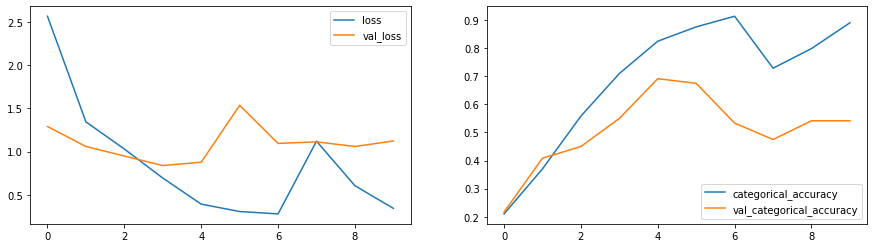

In [12]:
plot(history)

### Model 1 Output says:
- categorical_accuracy: 0.8907  
- val_categorical_accuracy: 0.5417

Model is overfit

### 2nd Model : Conv3D with BatchNormalization
### here Batch size = 40, No of epoch = 15

In [13]:
 model = Sequential()

 model.add(Conv3D(32, kernel_size=3, activation='relu', input_shape=input_shape))
 model.add(Conv3D(64, kernel_size=3, activation='relu'))
 model.add(MaxPooling3D(pool_size=(2, 2, 2)))
 model.add(BatchNormalization())

 model.add(Conv3D(128, kernel_size=3, activation='relu'))
 model.add(MaxPooling3D(pool_size=(1, 2, 2)))
 model.add(BatchNormalization())

 model.add(Conv3D(256, kernel_size=(1, 3, 3), activation='relu'))
 model.add(MaxPooling3D(pool_size=(1, 2, 2)))
 model.add(BatchNormalization())
 model.add(Conv3D(512, kernel_size=(1, 3, 3), activation='relu'))
 model.add(Conv3D(512, kernel_size=(1, 3, 3), activation='relu'))
 model.add(MaxPooling3D(pool_size=(1, 2, 2)))
 model.add(BatchNormalization())

 model.add(Flatten())
 model.add(Dense(512, activation='relu'))
 model.add(BatchNormalization())
 model.add(Dense(5, activation='softmax'))

In [14]:
num_epochs = 15              # choose the number of epochs

model_name = 'model_init' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    
if not os.path.exists(model_name):
    os.mkdir(model_name)
        
filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', save_freq='epoch')

LR =ReduceLROnPlateau(monitor='val_loss', factor=0.2, verbose=1, patience=4) # write the REducelronplateau code here
earlystop = EarlyStopping( monitor="val_loss", min_delta=0,patience=10,verbose=1)
callbacks_list = [checkpoint, LR, earlystop]

optimiser =tf.keras.optimizers.Adam() #write your optimizer
model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model.summary())   

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_2 (Conv3D)           (None, 14, 118, 118, 32)  2624      
                                                                 
 conv3d_3 (Conv3D)           (None, 12, 116, 116, 64)  55360     
                                                                 
 max_pooling3d_2 (MaxPooling  (None, 6, 58, 58, 64)    0         
 3D)                                                             
                                                                 
 batch_normalization (BatchN  (None, 6, 58, 58, 64)    256       
 ormalization)                                                   
                                                                 
 conv3d_4 (Conv3D)           (None, 4, 56, 56, 128)    221312    
                                                                 
 max_pooling3d_3 (MaxPooling  (None, 4, 28, 28, 128)  

In [15]:
history=model.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Epoch 1/15
17/17 [==============================] - ETA: 0s - loss: 2.5746 - categorical_accuracy: 0.4315
Epoch 00001: saving model to model_init_2022-06-1501_54_49.039378/model-00001-2.57456-0.43149-38.72210-0.17500.h5
17/17 [==============================] - 86s 5s/step - loss: 2.5746 - categorical_accuracy: 0.4315 - val_loss: 38.7221 - val_categorical_accuracy: 0.1750 - lr: 0.0010
Epoch 2/15
17/17 [==============================] - ETA: 0s - loss: 1.0405 - categorical_accuracy: 0.5831
Epoch 00002: saving model to model_init_2022-06-1501_54_49.039378/model-00002-1.04046-0.58309-6.85841-0.20833.h5
17/17 [==============================] - 70s 4s/step - loss: 1.0405 - categorical_accuracy: 0.5831 - val_loss: 6.8584 - val_categorical_accuracy: 0.2083 - lr: 0.0010
Epoch 3/15
17/17 [==============================] - ETA: 0s - loss: 0.7717 - categorical_accuracy: 0.6662
Epoch 00003: saving model to model_init_2022-06-1501_54_49.039378/model-00003-0.77174-0.66618-7.72963-0.20000.h5
17/17 [==

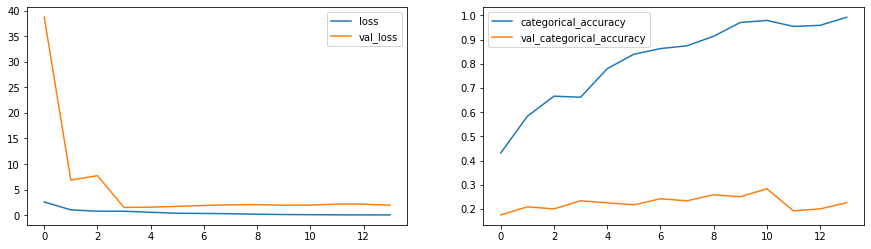

In [16]:
plot(history)

### Model 2 Output says:
- categorical_accuracy: 0.9927  
- val_categorical_accuracy: 0.2250

Model is early stopping as accuracy is not increasing with each consistnet epoch.

### 3rd Model : Conv3D with BatchNormalization and Dropout
### here batch_size = 40, No of epoch = 20

In [9]:
model = Sequential()

model.add(Conv3D(32, kernel_size=3, activation='relu', input_shape=input_shape))
model.add(Conv3D(64, kernel_size=3, activation='relu'))
model.add(MaxPooling3D(pool_size=(2, 2, 2)))
model.add(BatchNormalization())
model.add(Dropout(0.5))

model.add(Conv3D(128, kernel_size=3, activation='relu'))
model.add(MaxPooling3D(pool_size=(1, 2, 2)))
model.add(BatchNormalization())
model.add(Dropout(0.5))

model.add(Conv3D(256, kernel_size=(1, 3, 3), activation='relu'))
model.add(MaxPooling3D(pool_size=(1, 2, 2)))
model.add(BatchNormalization())
model.add(Dropout(0.5))

model.add(Conv3D(512, kernel_size=(1, 3, 3), activation='relu'))
model.add(Conv3D(512, kernel_size=(1, 3, 3), activation='relu'))
model.add(MaxPooling3D(pool_size=(1, 2, 2)))
model.add(BatchNormalization())
model.add(Dropout(0.5))

model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(BatchNormalization())
model.add(Dense(5, activation='softmax'))

2022-06-15 05:53:23.945842: W tensorflow/core/common_runtime/gpu/gpu_bfc_allocator.cc:39] Overriding allow_growth setting because the TF_FORCE_GPU_ALLOW_GROWTH environment variable is set. Original config value was 0.
2022-06-15 05:53:23.945904: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 14803 MB memory:  -> device: 0, name: Quadro RTX 5000, pci bus id: 0000:1c:00.0, compute capability: 7.5


In [15]:
num_epochs = 20              # choose the number of epochs

model_name = 'model_init' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    
if not os.path.exists(model_name):
    os.mkdir(model_name)
        
filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', save_freq='epoch')

LR =ReduceLROnPlateau(monitor='val_loss', factor=0.2, verbose=1, patience=4) # write the REducelronplateau code here
earlystop = EarlyStopping( monitor="val_loss", min_delta=0,patience=10,verbose=1)
callbacks_list = [checkpoint, LR, earlystop]

optimiser =tf.keras.optimizers.Adam() #write your optimizer
model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model.summary()) 

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d (Conv3D)             (None, 14, 118, 118, 32)  2624      
                                                                 
 conv3d_1 (Conv3D)           (None, 12, 116, 116, 64)  55360     
                                                                 
 max_pooling3d (MaxPooling3D  (None, 6, 58, 58, 64)    0         
 )                                                               
                                                                 
 batch_normalization (BatchN  (None, 6, 58, 58, 64)    256       
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 6, 58, 58, 64)     0         
                                                                 
 conv3d_2 (Conv3D)           (None, 4, 56, 56, 128)    2

In [16]:
history=model.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Source path =  /datasets/Project_data/train ; batch size = 40
Epoch 1/20


2022-06-15 05:55:58.339444: I tensorflow/stream_executor/cuda/cuda_dnn.cc:377] Loaded cuDNN version 8302


17/17 [==============================] - ETA: 0s - loss: 2.3382 - categorical_accuracy: 0.3994Source path =  /datasets/Project_data/val ; batch size = 40

Epoch 00001: saving model to model_init_2022-06-1505_52_53.718290/model-00001-2.33823-0.39942-3.52200-0.20833.h5
17/17 [==============================] - 91s 5s/step - loss: 2.3382 - categorical_accuracy: 0.3994 - val_loss: 3.5220 - val_categorical_accuracy: 0.2083 - lr: 0.0010
Epoch 2/20
17/17 [==============================] - ETA: 0s - loss: 1.1003 - categorical_accuracy: 0.5394
Epoch 00002: saving model to model_init_2022-06-1505_52_53.718290/model-00002-1.10027-0.53936-2.07787-0.17500.h5
17/17 [==============================] - 76s 5s/step - loss: 1.1003 - categorical_accuracy: 0.5394 - val_loss: 2.0779 - val_categorical_accuracy: 0.1750 - lr: 0.0010
Epoch 3/20
17/17 [==============================] - ETA: 0s - loss: 0.9042 - categorical_accuracy: 0.6195
Epoch 00003: saving model to model_init_2022-06-1505_52_53.718290/model-000

plot(history)

### Model 3 Output says:
- categorical_accuracy: 0.9431  
- val_categorical_accuracy: 0.1667

Model is early stopping as accuracy is not increasing with each consistnet epoch.

### 4th Model: Conv3D with BatchNormalization,Dropout and GlobalAveragePooling
### batch_size=40,epoch=30      

In [21]:
model = Sequential()

model.add(Conv3D(32, kernel_size=3, activation='relu', input_shape=input_shape))
model.add(Conv3D(64, kernel_size=3, activation='relu'))
model.add(MaxPooling3D(pool_size=(2, 2, 2)))
model.add(BatchNormalization())
model.add(Dropout(0.2))

model.add(Conv3D(128, kernel_size=3, activation='relu'))
model.add(MaxPooling3D(pool_size=(1, 2, 2)))
model.add(BatchNormalization())
model.add(Dropout(0.2))
model.add(Conv3D(256, kernel_size=(1, 3, 3), activation='relu'))
model.add(MaxPooling3D(pool_size=(1, 2, 2)))
model.add(BatchNormalization())
model.add(Dropout(0.2))

model.add(GlobalAveragePooling3D())
model.add(Dense(512, activation='relu'))
model.add(BatchNormalization())
model.add(Dense(5, activation='softmax'))

In [22]:
num_epochs = 30              # choose the number of epochs

model_name = 'model_init' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    
if not os.path.exists(model_name):
    os.mkdir(model_name)
        
filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', save_freq='epoch')

LR =ReduceLROnPlateau(monitor='val_loss', factor=0.2, verbose=1, patience=4) # write the REducelronplateau code here
earlystop = EarlyStopping( monitor="val_loss", min_delta=0,patience=10,verbose=1)
callbacks_list = [checkpoint, LR, earlystop]

optimiser =tf.keras.optimizers.Adam() #write your optimizer
model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model.summary()) 

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_14 (Conv3D)          (None, 14, 118, 118, 32)  2624      
                                                                 
 conv3d_15 (Conv3D)          (None, 12, 116, 116, 64)  55360     
                                                                 
 max_pooling3d_10 (MaxPoolin  (None, 6, 58, 58, 64)    0         
 g3D)                                                            
                                                                 
 batch_normalization_10 (Bat  (None, 6, 58, 58, 64)    256       
 chNormalization)                                                
                                                                 
 dropout_4 (Dropout)         (None, 6, 58, 58, 64)     0         
                                                                 
 conv3d_16 (Conv3D)          (None, 4, 56, 56, 128)   

In [23]:
history=model.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Epoch 1/30
17/17 [==============================] - ETA: 0s - loss: 1.6105 - categorical_accuracy: 0.3921
Epoch 00001: saving model to model_init_2022-06-1501_54_49.039378/model-00001-1.61051-0.39213-1.73833-0.19167.h5
17/17 [==============================] - 67s 4s/step - loss: 1.6105 - categorical_accuracy: 0.3921 - val_loss: 1.7383 - val_categorical_accuracy: 0.1917 - lr: 0.0010
Epoch 2/30
17/17 [==============================] - ETA: 0s - loss: 1.0162 - categorical_accuracy: 0.5598
Epoch 00002: saving model to model_init_2022-06-1501_54_49.039378/model-00002-1.01624-0.55977-1.44348-0.18333.h5
17/17 [==============================] - 66s 4s/step - loss: 1.0162 - categorical_accuracy: 0.5598 - val_loss: 1.4435 - val_categorical_accuracy: 0.1833 - lr: 0.0010
Epoch 3/30
17/17 [==============================] - ETA: 0s - loss: 0.8771 - categorical_accuracy: 0.6254
Epoch 00003: saving model to model_init_2022-06-1501_54_49.039378/model-00003-0.87708-0.62536-1.43031-0.18333.h5
17/17 [====

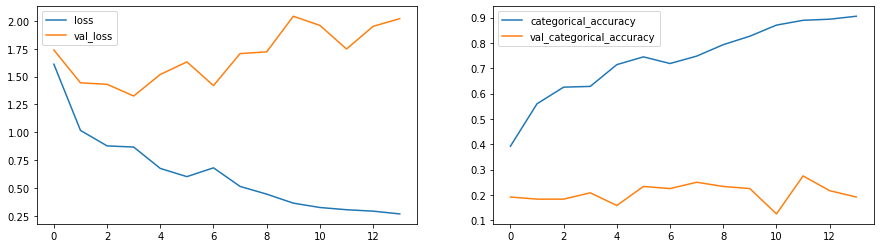

In [26]:
 plot(history)

### Model 4 Output says:
- categorical_accuracy: 0.9052  
- val_categorical_accuracy: 0.1917

Model is early stopping as accuracy is not increasing with each consistnet epoch.

### 5th Model: Conv 2D and LSTM
### here Batch_size=40, No of epoch = 40

In [24]:
model = Sequential()
model.add(TimeDistributed(Conv2D(32, (3,3), activation='relu'), input_shape=input_shape))
model.add(TimeDistributed(MaxPooling2D((2,2))))
model.add(BatchNormalization())
model.add(Dropout(0.2))

model.add(TimeDistributed(Conv2D(64, (3,3), activation='relu')))
model.add(TimeDistributed(MaxPooling2D((2,2))))
model.add(BatchNormalization())
model.add(Dropout(0.2))

model.add(TimeDistributed(GlobalAveragePooling2D()))
model.add(TimeDistributed(Dense(64, activation='relu')))
model.add(BatchNormalization())
model.add(Dropout(0.2))

model.add(LSTM(128))
model.add(BatchNormalization())
model.add(Dense(5, activation='softmax'))

In [25]:
num_epochs = 40              # choose the number of epochs

model_name = 'model_init' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    
if not os.path.exists(model_name):
    os.mkdir(model_name)
        
filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', save_freq='epoch')

LR =ReduceLROnPlateau(monitor='val_loss', factor=0.2, verbose=1, patience=4) # write the REducelronplateau code here
earlystop = EarlyStopping( monitor="val_categorical_accuracy",mode='max',patience=10,verbose=1)
callbacks_list = [checkpoint, LR, earlystop]

optimiser =tf.keras.optimizers.Adam() #write your optimizer
model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model.summary()) 

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed (TimeDistr  (None, 16, 118, 118, 32)  896      
 ibuted)                                                         
                                                                 
 time_distributed_1 (TimeDis  (None, 16, 59, 59, 32)   0         
 tributed)                                                       
                                                                 
 batch_normalization_14 (Bat  (None, 16, 59, 59, 32)   128       
 chNormalization)                                                
                                                                 
 dropout_7 (Dropout)         (None, 16, 59, 59, 32)    0         
                                                                 
 time_distributed_2 (TimeDis  (None, 16, 57, 57, 64)   18496     
 tributed)                                            

In [27]:
 history=model.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Epoch 1/40
17/17 [==============================] - ETA: 0s - loss: 1.4042 - categorical_accuracy: 0.4373
Epoch 00001: saving model to model_init_2022-06-1501_54_49.039378/model-00001-1.40418-0.43732-1.33804-0.10833.h5
17/17 [==============================] - 66s 4s/step - loss: 1.4042 - categorical_accuracy: 0.4373 - val_loss: 1.3380 - val_categorical_accuracy: 0.1083 - lr: 0.0010
Epoch 2/40
17/17 [==============================] - ETA: 0s - loss: 1.0463 - categorical_accuracy: 0.5481
Epoch 00002: saving model to model_init_2022-06-1501_54_49.039378/model-00002-1.04627-0.54810-1.33500-0.17500.h5
17/17 [==============================] - 66s 4s/step - loss: 1.0463 - categorical_accuracy: 0.5481 - val_loss: 1.3350 - val_categorical_accuracy: 0.1750 - lr: 0.0010
Epoch 3/40
17/17 [==============================] - ETA: 0s - loss: 0.9385 - categorical_accuracy: 0.5948
Epoch 00003: saving model to model_init_2022-06-1501_54_49.039378/model-00003-0.93853-0.59475-1.33474-0.19167.h5
17/17 [====

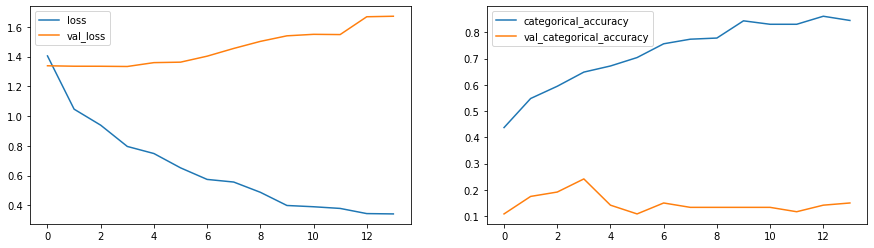

In [28]:
plot(history)

### Model 5 Output says:
- categorical_accuracy: 0.8455  
- val_categorical_accuracy: 0.1500

Model is early stopping as accuracy is not increasing with each consistnet epoch.

### 6th Model: Conv2D + GRU
### here Batch_size = 40, No of epoch = 40

In [29]:
 model = Sequential()
 model.add(TimeDistributed(Conv2D(32, (3,3), activation='relu'), input_shape=input_shape))
 model.add(TimeDistributed(MaxPooling2D((2,2))))
 model.add(BatchNormalization())
 model.add(Dropout(0.2))

 model.add(TimeDistributed(Conv2D(64, (3,3), activation='relu')))
 model.add(TimeDistributed(MaxPooling2D((2,2))))
 model.add(BatchNormalization())
 model.add(Dropout(0.2))

 model.add(TimeDistributed(GlobalAveragePooling2D()))
 model.add(TimeDistributed(Dense(64, activation='relu')))
 model.add(BatchNormalization())
 model.add(Dropout(0.2))

 model.add(GRU(128))
 model.add(BatchNormalization())
 model.add(Dense(5, activation='softmax'))

In [30]:
num_epochs = 40              # choose the number of epochs

model_name = 'model_init' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    
if not os.path.exists(model_name):
    os.mkdir(model_name)
        
filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', save_freq='epoch')

LR =ReduceLROnPlateau(monitor='val_loss', factor=0.2, verbose=1, patience=4) # write the REducelronplateau code here
earlystop = EarlyStopping( monitor="val_loss", min_delta=0,patience=10,verbose=1)
callbacks_list = [checkpoint, LR, earlystop]

optimiser =tf.keras.optimizers.Adam() #write your optimizer
model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model.summary()) 

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_6 (TimeDis  (None, 16, 118, 118, 32)  896      
 tributed)                                                       
                                                                 
 time_distributed_7 (TimeDis  (None, 16, 59, 59, 32)   0         
 tributed)                                                       
                                                                 
 batch_normalization_18 (Bat  (None, 16, 59, 59, 32)   128       
 chNormalization)                                                
                                                                 
 dropout_10 (Dropout)        (None, 16, 59, 59, 32)    0         
                                                                 
 time_distributed_8 (TimeDis  (None, 16, 57, 57, 64)   18496     
 tributed)                                            

In [31]:
 history=model.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Epoch 1/40
17/17 [==============================] - ETA: 0s - loss: 1.3736 - categorical_accuracy: 0.4082
Epoch 00001: saving model to model_init_2022-06-1501_54_49.039378/model-00001-1.37361-0.40816-1.33788-0.12500.h5
17/17 [==============================] - 68s 4s/step - loss: 1.3736 - categorical_accuracy: 0.4082 - val_loss: 1.3379 - val_categorical_accuracy: 0.1250 - lr: 0.0010
Epoch 2/40
17/17 [==============================] - ETA: 0s - loss: 1.0691 - categorical_accuracy: 0.4825
Epoch 00002: saving model to model_init_2022-06-1501_54_49.039378/model-00002-1.06910-0.48251-1.32660-0.15833.h5
17/17 [==============================] - 62s 4s/step - loss: 1.0691 - categorical_accuracy: 0.4825 - val_loss: 1.3266 - val_categorical_accuracy: 0.1583 - lr: 0.0010
Epoch 3/40
17/17 [==============================] - ETA: 0s - loss: 0.9157 - categorical_accuracy: 0.6108
Epoch 00003: saving model to model_init_2022-06-1501_54_49.039378/model-00003-0.91572-0.61079-1.32375-0.16667.h5
17/17 [====

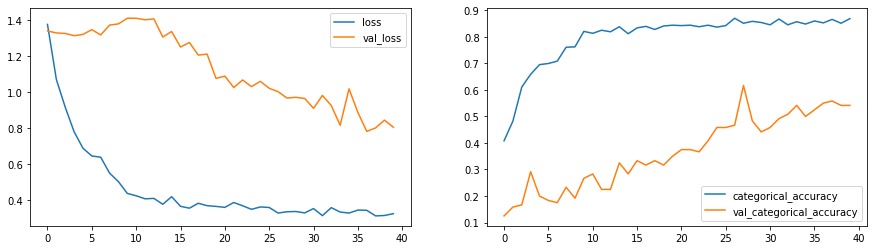

In [32]:
 plot(history)

### Model 6 Output says:
- categorical_accuracy: 0.8688  
- val_categorical_accuracy: 0.5417

Model is overfit.

### 7th Model: TransferLearning (VGG16) + LSTM
### here Batch_size = 40, No of epoch = 30

In [33]:
 from keras.applications.vgg16 import VGG16
 VGG16_transfer = tf.keras.applications.vgg16.VGG16(weights='imagenet', include_top=False)
 model = Sequential()
 model.add(TimeDistributed(VGG16_transfer,input_shape=input_shape))
 for layer in model.layers:
     layer.trainable = False

 model.add(TimeDistributed(BatchNormalization()))
 model.add(TimeDistributed(MaxPooling2D((2, 2))))
 model.add(TimeDistributed(Flatten()))
 model.add(LSTM(128))
 model.add(Dropout(0.25))
 model.add(Dense(64,activation='relu'))
 model.add(Dropout(0.25))
       
 model.add(Dense(5, activation='softmax'))

58900480/58889256 [==============================] - 1s 0us/step


In [34]:
num_epochs = 30              # choose the number of epochs

model_name = 'model_init' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    
if not os.path.exists(model_name):
    os.mkdir(model_name)
        
filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', save_freq='epoch')

LR =ReduceLROnPlateau(monitor='val_loss', factor=0.2, verbose=1, patience=4) # write the REducelronplateau code here
earlystop = EarlyStopping( monitor="val_loss", min_delta=0,patience=10,verbose=1)
callbacks_list = [checkpoint, LR, earlystop]

optimiser =tf.keras.optimizers.Adam() #write your optimizer
model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model.summary()) 

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_12 (TimeDi  (None, 16, 3, 3, 512)    14714688  
 stributed)                                                      
                                                                 
 time_distributed_13 (TimeDi  (None, 16, 3, 3, 512)    2048      
 stributed)                                                      
                                                                 
 time_distributed_14 (TimeDi  (None, 16, 1, 1, 512)    0         
 stributed)                                                      
                                                                 
 time_distributed_15 (TimeDi  (None, 16, 512)          0         
 stributed)                                                      
                                                                 
 lstm_1 (LSTM)               (None, 128)              

In [35]:
history=model.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Epoch 1/30
17/17 [==============================] - ETA: 0s - loss: 1.4878 - categorical_accuracy: 0.3236
Epoch 00001: saving model to model_init_2022-06-1501_54_49.039378/model-00001-1.48777-0.32362-1.20670-0.34167.h5
17/17 [==============================] - 71s 4s/step - loss: 1.4878 - categorical_accuracy: 0.3236 - val_loss: 1.2067 - val_categorical_accuracy: 0.3417 - lr: 0.0010
Epoch 2/30
17/17 [==============================] - ETA: 0s - loss: 1.1312 - categorical_accuracy: 0.5394
Epoch 00002: saving model to model_init_2022-06-1501_54_49.039378/model-00002-1.13123-0.53936-1.14033-0.38333.h5
17/17 [==============================] - 67s 4s/step - loss: 1.1312 - categorical_accuracy: 0.5394 - val_loss: 1.1403 - val_categorical_accuracy: 0.3833 - lr: 0.0010
Epoch 3/30
17/17 [==============================] - ETA: 0s - loss: 0.8374 - categorical_accuracy: 0.6866
Epoch 00003: saving model to model_init_2022-06-1501_54_49.039378/model-00003-0.83741-0.68659-0.98483-0.45000.h5
17/17 [====

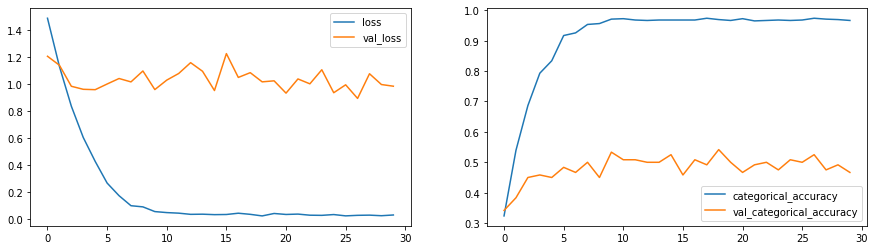

In [36]:
plot(history)

### Model 7 Output says:
- categorical_accuracy: 0.9665  
- val_categorical_accuracy: 0.4667

Model is overfit.

### 8th Model: VGG16 + LSTM with BatchNormalization
### here batch_size=40, No of epoch = 30

In [37]:
 from keras.applications.vgg16 import VGG16
 VGG16_transfer = tf.keras.applications.vgg16.VGG16(weights='imagenet', include_top=False)
 model = Sequential()
 model.add(TimeDistributed(VGG16_transfer,input_shape=input_shape))
 for layer in model.layers:
     layer.trainable = False

 model.add(TimeDistributed(BatchNormalization()))
 model.add(TimeDistributed(MaxPooling2D((2, 2))))
 model.add(TimeDistributed(Flatten()))
 model.add(LSTM(128))
 model.add(BatchNormalization())
 model.add(Dense(64,activation='relu'))
 model.add(Dropout(0.25))
        
 model.add(Dense(5, activation='softmax'))

In [38]:
num_epochs = 30              # choose the number of epochs

model_name = 'model_init' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    
if not os.path.exists(model_name):
    os.mkdir(model_name)
        
filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', save_freq='epoch')

LR =ReduceLROnPlateau(monitor='val_loss', factor=0.2, verbose=1, patience=4) # write the REducelronplateau code here
earlystop = EarlyStopping( monitor="val_loss", min_delta=0,patience=10,verbose=1)
callbacks_list = [checkpoint, LR, earlystop]

optimiser =tf.keras.optimizers.Adam() #write your optimizer
model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model.summary()) 

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_16 (TimeDi  (None, 16, 3, 3, 512)    14714688  
 stributed)                                                      
                                                                 
 time_distributed_17 (TimeDi  (None, 16, 3, 3, 512)    2048      
 stributed)                                                      
                                                                 
 time_distributed_18 (TimeDi  (None, 16, 1, 1, 512)    0         
 stributed)                                                      
                                                                 
 time_distributed_19 (TimeDi  (None, 16, 512)          0         
 stributed)                                                      
                                                                 
 lstm_2 (LSTM)               (None, 128)              

In [39]:
 history=model.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Epoch 1/30
17/17 [==============================] - ETA: 0s - loss: 1.5169 - categorical_accuracy: 0.3746
Epoch 00001: saving model to model_init_2022-06-1501_54_49.039378/model-00001-1.51691-0.37464-1.27466-0.43333.h5
17/17 [==============================] - 67s 4s/step - loss: 1.5169 - categorical_accuracy: 0.3746 - val_loss: 1.2747 - val_categorical_accuracy: 0.4333 - lr: 0.0010
Epoch 2/30
17/17 [==============================] - ETA: 0s - loss: 0.8374 - categorical_accuracy: 0.6647
Epoch 00002: saving model to model_init_2022-06-1501_54_49.039378/model-00002-0.83738-0.66472-1.24693-0.43333.h5
17/17 [==============================] - 68s 4s/step - loss: 0.8374 - categorical_accuracy: 0.6647 - val_loss: 1.2469 - val_categorical_accuracy: 0.4333 - lr: 0.0010
Epoch 3/30
17/17 [==============================] - ETA: 0s - loss: 0.5203 - categorical_accuracy: 0.8178
Epoch 00003: saving model to model_init_2022-06-1501_54_49.039378/model-00003-0.52027-0.81778-1.16754-0.50833.h5
17/17 [====

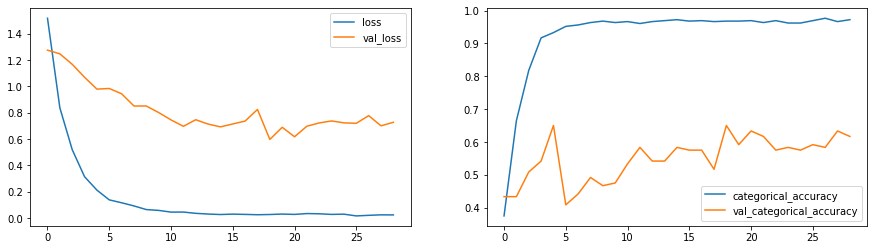

In [40]:
plot(history)

### Model 8 Output says:
- categorical_accuracy: 0.9723  
- val_categorical_accuracy: 0.6167

Model is still overfit.

### 9th Model: VGG16 + GRU
### here batch_size=40, No of epoch = 20

In [41]:
 from keras.applications.vgg16 import VGG16
 VGG16_transfer = tf.keras.applications.vgg16.VGG16(weights='imagenet', include_top=False)
 model = Sequential()
 model.add(TimeDistributed(VGG16_transfer,input_shape=input_shape))
 for layer in model.layers:
     layer.trainable = False

 model.add(TimeDistributed(BatchNormalization()))
 model.add(TimeDistributed(MaxPooling2D((2, 2))))
 model.add(TimeDistributed(Flatten()))
 model.add(GRU(128))
 model.add(BatchNormalization())
 model.add(Dropout(0.5))
 model.add(Dense(64,activation='relu'))
 model.add(Dropout(0.5))
        
 model.add(Dense(5, activation='softmax'))

In [42]:
num_epochs = 20              # choose the number of epochs

model_name = 'model_init' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    
if not os.path.exists(model_name):
    os.mkdir(model_name)
        
filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', save_freq='epoch')

LR =ReduceLROnPlateau(monitor='val_loss', factor=0.2, verbose=1, patience=4) # write the REducelronplateau code here
earlystop = EarlyStopping( monitor="val_loss", min_delta=0,patience=10,verbose=1)
callbacks_list = [checkpoint, LR, earlystop]

optimiser =tf.keras.optimizers.Adam() #write your optimizer
model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model.summary()) 

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_20 (TimeDi  (None, 16, 3, 3, 512)    14714688  
 stributed)                                                      
                                                                 
 time_distributed_21 (TimeDi  (None, 16, 3, 3, 512)    2048      
 stributed)                                                      
                                                                 
 time_distributed_22 (TimeDi  (None, 16, 1, 1, 512)    0         
 stributed)                                                      
                                                                 
 time_distributed_23 (TimeDi  (None, 16, 512)          0         
 stributed)                                                      
                                                                 
 gru_1 (GRU)                 (None, 128)              

In [43]:
history=model.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                     callbacks=callbacks_list, validation_data=val_generator, 
                     validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Epoch 1/20
17/17 [==============================] - ETA: 0s - loss: 2.7016 - categorical_accuracy: 0.2332
Epoch 00001: saving model to model_init_2022-06-1501_54_49.039378/model-00001-2.70155-0.23324-1.27464-0.31667.h5
17/17 [==============================] - 75s 5s/step - loss: 2.7016 - categorical_accuracy: 0.2332 - val_loss: 1.2746 - val_categorical_accuracy: 0.3167 - lr: 0.0010
Epoch 2/20
17/17 [==============================] - ETA: 0s - loss: 1.9115 - categorical_accuracy: 0.3746
Epoch 00002: saving model to model_init_2022-06-1501_54_49.039378/model-00002-1.91155-0.37464-1.10274-0.37500.h5
17/17 [==============================] - 63s 4s/step - loss: 1.9115 - categorical_accuracy: 0.3746 - val_loss: 1.1027 - val_categorical_accuracy: 0.3750 - lr: 0.0010
Epoch 3/20
17/17 [==============================] - ETA: 0s - loss: 1.5369 - categorical_accuracy: 0.4388
Epoch 00003: saving model to model_init_2022-06-1501_54_49.039378/model-00003-1.53692-0.43878-1.04173-0.44167.h5
17/17 [====

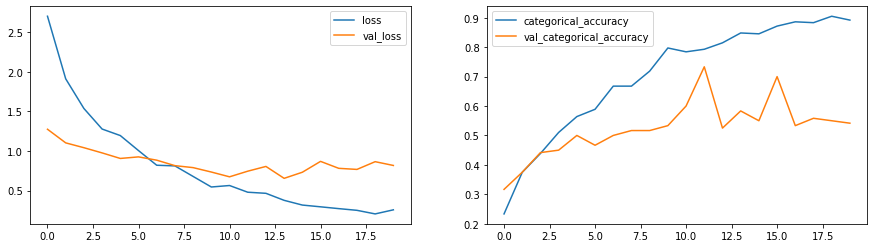

In [44]:
 plot(history)

### Model 9 Output says:
- categorical_accuracy: 0.8921  
- val_categorical_accuracy: 0.5417

Model is overfit.

## 10th Model: TransferLearning(Mobilenet) + GRU
### here batch size = 40, No of epoch = 15

In [13]:
from keras.applications import mobilenet

mobilenet_transfer = mobilenet.MobileNet(weights='imagenet', include_top=False)

model = Sequential()
model.add(TimeDistributed(mobilenet_transfer,input_shape=input_shape))
 
model.add(TimeDistributed(BatchNormalization()))
model.add(TimeDistributed(MaxPooling2D((2, 2))))
model.add(TimeDistributed(Flatten()))

model.add(GRU(128))
model.add(Dropout(0.25))
        
model.add(Dense(128,activation='relu'))
model.add(Dropout(0.25))
        
model.add(Dense(5, activation='softmax'))

17235968/17225924 [==============================] - 1s 0us/step


In [14]:
num_epochs = 15              # choose the number of epochs

model_name = 'model_init' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    
if not os.path.exists(model_name):
    os.mkdir(model_name)
        
filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=False, mode='auto', save_freq='epoch')

LR =ReduceLROnPlateau(monitor='val_loss', factor=0.2, verbose=1, patience=4) # write the REducelronplateau code here
earlystop = EarlyStopping( monitor="val_loss", min_delta=0,patience=10,verbose=1)
callbacks_list = [checkpoint, LR, earlystop]

optimiser =tf.keras.optimizers.Adam() #write your optimizer
model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model.summary())

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed (TimeDistr  (None, 16, 3, 3, 1024)   3228864   
 ibuted)                                                         
                                                                 
 time_distributed_1 (TimeDis  (None, 16, 3, 3, 1024)   4096      
 tributed)                                                       
                                                                 
 time_distributed_2 (TimeDis  (None, 16, 1, 1, 1024)   0         
 tributed)                                                       
                                                                 
 time_distributed_3 (TimeDis  (None, 16, 1024)         0         
 tributed)                                                       
                                                                 
 gru (GRU)                   (None, 128)              

In [15]:
history=model.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Source path =  /datasets/Project_data/train ; batch size = 40
Epoch 1/15


2022-06-15 06:38:23.297486: I tensorflow/stream_executor/cuda/cuda_dnn.cc:377] Loaded cuDNN version 8302


17/17 [==============================] - ETA: 0s - loss: 1.1677 - categorical_accuracy: 0.5306Source path =  /datasets/Project_data/val ; batch size = 40

Epoch 00001: val_loss improved from inf to 0.91708, saving model to model_init_2022-06-1506_36_52.625838/model-00001-1.16773-0.53061-0.91708-0.45000.h5
17/17 [==============================] - 72s 4s/step - loss: 1.1677 - categorical_accuracy: 0.5306 - val_loss: 0.9171 - val_categorical_accuracy: 0.4500 - lr: 0.0010
Epoch 2/15
17/17 [==============================] - ETA: 0s - loss: 0.3747 - categorical_accuracy: 0.8397
Epoch 00002: val_loss improved from 0.91708 to 0.62535, saving model to model_init_2022-06-1506_36_52.625838/model-00002-0.37472-0.83965-0.62535-0.52500.h5
17/17 [==============================] - 66s 4s/step - loss: 0.3747 - categorical_accuracy: 0.8397 - val_loss: 0.6253 - val_categorical_accuracy: 0.5250 - lr: 0.0010
Epoch 3/15
17/17 [==============================] - ETA: 0s - loss: 0.1750 - categorical_accuracy: 

### View Result

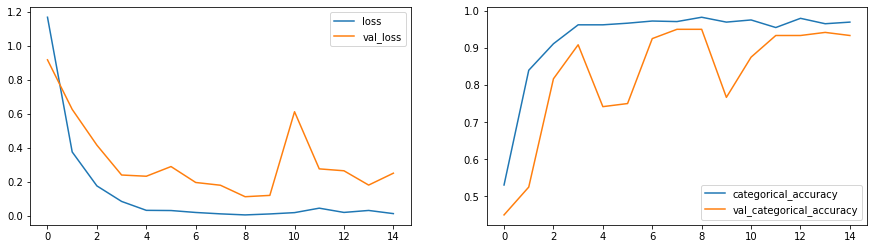

In [16]:
plot(history)

### Conclusion:

### Model 10 Output says:
- categorical_accuracy: 0.9694  
- val_categorical_accuracy: 0.9333

Model is robust.
With different learning method, change in different no of epoch and training parameters from that Model 10 (Mobilenet + GRU) gave best accuracy when compared to all above models.
